# Allocation using PartitionedProcess, Evolver, Requester, and Allocator

In [1]:
# Make sure notebook runs out of vivarium-ecoli directory
import sys, os

# get the path to the notebook, and change working directory
notebook_path = sys.path[0][:sys.path[0].index('notebooks')]
sys.path.append(notebook_path)
os.chdir(sys.path[-1])
cwd = os.getcwd()

# print(cwd)

In [2]:
import numpy as np

from vivarium.core.process import Process
from vivarium.core.store import Store
from vivarium.core.engine import Engine, pp
from vivarium.core.composer import Composite
from vivarium.core.composition import simulate_process, simulate_composite
from vivarium.plots.topology import plot_topology

from ecoli.processes.allocator import Allocator
from ecoli.processes.partition import PartitionedProcess, Evolver, Requester

topology_settings = {
    'buffer': 1,
    'show_ports': False,
    'node_size': 10000,
    'dashed_edges': True,
    'node_distance': 4,
    'graph_format': 'hierarchy',
}

## Make a Partitioned Process

In [3]:
MOLECULE_IDS = ['molecule_A']

class Example(PartitionedProcess):
    name = 'example'
    topology = {'port': ('store',)}
    def ports_schema(self):
        return {
            'port': {
                mol_id: {
                    '_default': 100.,
                    '_properties': {'bulk': True}
                } 
                for mol_id in MOLECULE_IDS}}
    def calculate_request(self, timestep, states):
        # request molecules
        return {
            'port': {
                mol_id: 10 
                for mol_id in MOLECULE_IDS}}
    def evolve_state(self, timestep, states):
        allocated = states['port']
        # use all allocated molecules
        return {
            'port': allocated}

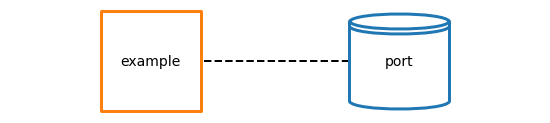

In [4]:
example_1 = Example()
process_topo_fig = plot_topology(example_1, topology_settings)

## Make an Evolver for the Example PartitionedProcess

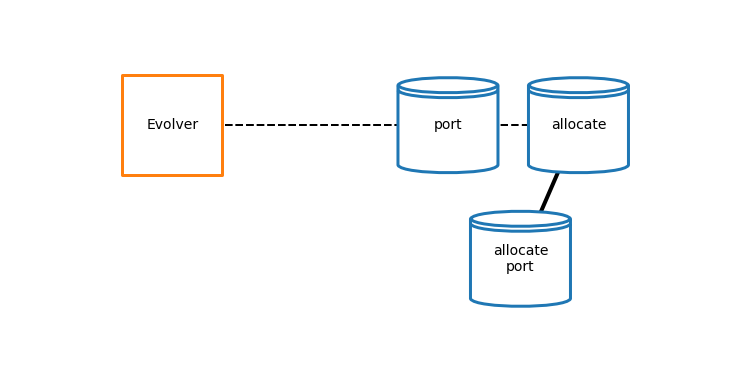

In [5]:
evolver_1 = Evolver({'process': example_1})
evolver_topo_fig = plot_topology(evolver_1, topology_settings)

## Make an Requester for the Example PartitionedProcess

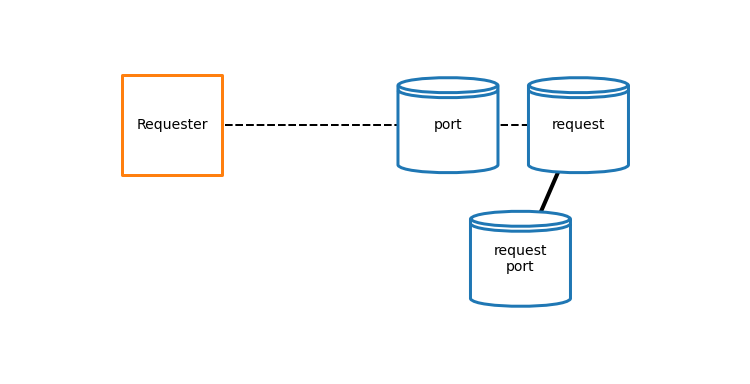

In [6]:
requester_1 = Requester({'process': example_1})
requester_topo_fig = plot_topology(requester_1, topology_settings)

## Make a second example partitioned process

This example processes will be wired with the first example through an Allocator

In [7]:
example_2 = Example()
evolver_2 = Evolver({'process': example_2})
requester_2 = Requester({'process': example_2})

## Make an Allocator

In [8]:
allocator_config = {
    'process_names': ['example_1', 'example_2'],
    'molecule_names': np.array(MOLECULE_IDS),
    'seed': 0,
    'custom_priorities': {
        'example_1': 1, 
        'example_2': 2,
    }
}

In [9]:
allocator = Allocator(allocator_config)

## Wire together a Partitioning Composite

In [10]:
evolver_1.ports_schema()

{'port': {'molecule_A': {'_default': 100.0, '_properties': {'bulk': True}}},
 'allocate': {'port': {'molecule_A': {'_default': 100.0,
    '_properties': {'bulk': True},
    '_updater': 'set',
    '_emit': False}}}}

In [11]:
allocation_composite = Composite({
    'processes': {
        'evolver_1': evolver_1,
        'evolver_2': evolver_2,
        'requester_1': requester_1,
        'requester_2': requester_2,
        'allocator': allocator,
    },
    'topology': {
        'evolver_1': {
            'port': ('store1',),
            'allocate': {
                '_path': ('allocate','example_1'),
                'port': ('store1',)
            },
        },
        'evolver_2': {
            'port': ('store1',),
            'allocate': {
                '_path': ('allocate','example_2'),
                'port': ('store1',)
            },
        },
        'requester_1': {
            'port': ('store1',),
            'request': {
                '_path': ('request','example_1'),
                'port': ('store1',)
            },
        },
        'requester_2': {
            'port': ('store1',),
            'request': {
                '_path': ('request','example_1'),
                'port': ('store1',)
            },
        },
        'allocator': {
            'bulk': ('store1',),
            'allocate': ('allocate',),
            'request': ('request',)
        },
    }
})

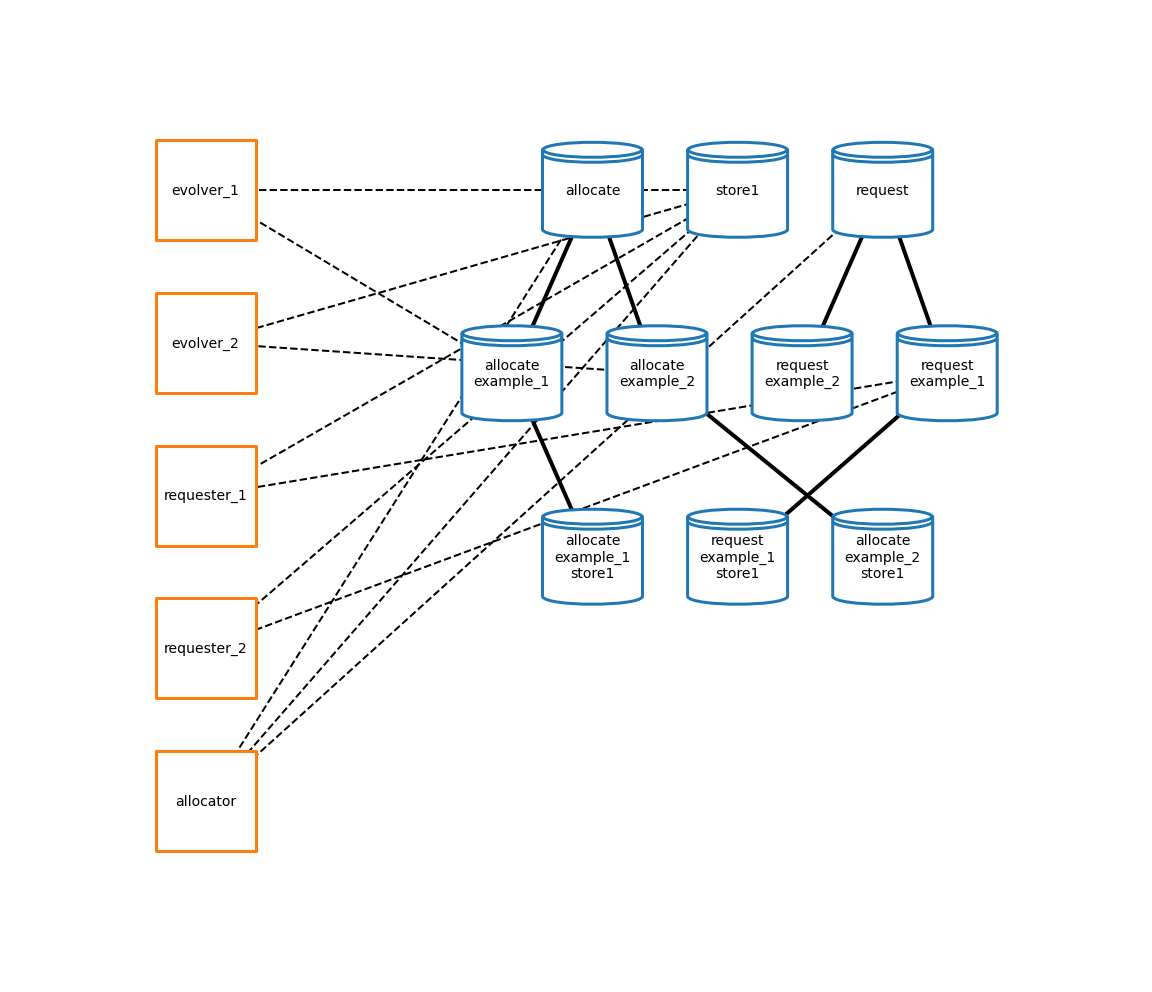

In [12]:
allocation_composite_topo_fig = plot_topology(allocation_composite, topology_settings)